# **Cosinor Regression Model**

In [6]:
import numpy as np
from statsmodels.api import OLS
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def design_matrix(t_hours, harmonics, period=24.0):
    """
    Build a design matrix with columns:
      [1, sin(2πnt / period), cos(2πnt / period) for each n in harmonics]
    """
    X_cols = [ np.ones_like(t_hours) ]
    for n in harmonics:
        ω = 2 * np.pi * n / period
        X_cols.append(np.sin(ω * t_hours))
        X_cols.append(np.cos(ω * t_hours))
    return np.column_stack(X_cols)

def fit_cosinor_with_cv(t_window, y_window, candidate_harmonics):
    """
    t_window: 1D array of timepoints (in hours) for a 5-day chunk (length 720).
    y_window: 1D array of normalized LFP values (length 720).
    candidate_harmonics: list of integers, e.g. [1, 2] for 24h & 12h components.
    """
    # 1. Set up 5-fold CV on 720 samples
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    # Count how many folds each harmonic is significant in
    sig_counts = {n: 0 for n in candidate_harmonics}

    for train_idx, test_idx in kf.split(t_window):
        # Training data
        t_tr = t_window[train_idx]
        y_tr = y_window[train_idx]
        X_tr = design_matrix(t_tr, harmonics=candidate_harmonics)

        # Fit full-model OLS on training set
        model_tr = OLS(y_tr, X_tr).fit()
        pvals = model_tr.pvalues[1:]  # skip intercept; then pairs (sin, cos) per harmonic

        # Check significance per harmonic
        for i, n in enumerate(candidate_harmonics):
            p_sin = pvals[2*i]
            p_cos = pvals[2*i + 1]
            if (p_sin < 0.05) or (p_cos < 0.05):
                sig_counts[n] += 1

    # 2. Retain harmonics significant in >= 3 folds
    retained = [n for n in candidate_harmonics if sig_counts[n] >= 3]

    # 3. Final fit on all 720 points with only retained harmonics
    X_full = design_matrix(t_window, harmonics=retained)
    final_model = OLS(y_window, X_full).fit()

    # 4. Extract amplitudes & acrophases for each retained harmonic
    amplitudes = []
    acrophases  = []  # in hours after midnight
    for i, n in enumerate(retained):
        A_sin = final_model.params[1 + 2*i]
        A_cos = final_model.params[1 + 2*i + 1]
        R     = np.sqrt(A_sin**2 + A_cos**2)
        # Acrophase φ satisfies:  A_sin*sin(2π t/24) + A_cos*cos(2π t/24) = R*cos(2π t/24 - φ)
        φ_rad = np.arctan2(-A_cos, A_sin)  # φ in radians
        φ_hr  = (φ_rad / (2*np.pi) * 24.0) % 24.0
        amplitudes.append(R)
        acrophases.append(φ_hr)

    # 5. Primary amplitude & acrophase
    if len(amplitudes) > 0:
        idx_max = int(np.argmax(amplitudes))
        primary_amplitude = amplitudes[idx_max]
        primary_acrophase = acrophases[idx_max]
    else:
        primary_amplitude = 0.0
        primary_acrophase = np.nan

    # 6. Compute cross-validated R2 (average over 5 folds)
    r2_list = []
    for train_idx, test_idx in kf.split(t_window):
        t_tr, t_te = t_window[train_idx], t_window[test_idx]
        y_tr, y_te = y_window[train_idx], y_window[test_idx]
        X_tr = design_matrix(t_tr, harmonics=retained)
        X_te = design_matrix(t_te, harmonics=retained)

        model_cv = OLS(y_tr, X_tr).fit()
        y_pred  = model_cv.predict(X_te)
        r2_fold = r2_score(y_te, y_pred)
        r2_list.append(r2_fold)
    daily_r2 = np.mean(r2_list)

    return primary_amplitude, primary_acrophase, daily_r2

def plot_lfp_heatmap(lfp_matrix, stimulus_days=None, vmin=-1, vmax=7, cmap='jet'):
    """
    Plot a heatmap of z-scored LFP power with optional stimulus event annotation. This is similar to what is used in the previous study.
    
    Parameters:
    - lfp_matrix: 2D np.ndarray (days x time bins)
    - stimulus_days: list of int, days when stimulus occurred
    - vmin, vmax: color scale limits
    - cmap: colormap
    """
    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(lfp_matrix, cmap=cmap, vmin=vmin, vmax=vmax, cbar_kws={'label': 'Z-scored LFP Power (9-12 Hz)'})
    plt.xlabel('Time of Day (bins)')
    plt.ylabel('Days')
    plt.title('LFP Power Heatmap')
    if stimulus_days is not None:
        for i, day in enumerate(stimulus_days):
            plt.axhline(day, color='magenta', linestyle='--', linewidth=2, label='Stimulus' if i == 0 else "")
        handles, labels = ax.get_legend_handles_labels()
        if 'Stimulus' not in labels:
            plt.legend(['Stimulus'], loc='upper right')
    plt.show()

def reshape_to_matrix(df):
    df['date'] = pd.to_datetime(df['Region start time']).dt.date
    df['hour'] = pd.to_datetime(df['Region start time']).dt.hour
    matrix = df.pivot(index='date', columns='hour', values='Pattern A Channel 2')
    return matrix.values  # shape: (n_days, 24)

def load_and_process_lfp_data(pre_path, post_path):
    # Load CSVs
    pre_df = pd.read_csv(pre_path)
    post_df = pd.read_csv(post_path)
    # Reshape to (days, 24)
    pre_matrix = reshape_to_matrix(pre_df)
    post_matrix = reshape_to_matrix(post_df)
    # Combine for visualization
    combined_matrix = np.vstack([pre_matrix, post_matrix])
    stimulus_day = pre_matrix.shape[0]
    # Plot heatmap with stimulus event
    plot_lfp_heatmap(combined_matrix, stimulus_days=[stimulus_day])
    return pre_matrix, post_matrix, combined_matrix, stimulus_day

def run_daily_cosinor_analysis(matrix):
    results = []
    n_days, n_hours = matrix.shape
    t_window = np.arange(n_hours)  # hours in a day
    cand_harmonics = [1, 2]  # 24h & 12h
    for i in range(n_days):
        y_window = (matrix[i] - np.mean(matrix[i])) / np.std(matrix[i])  # z-score per day
        amp, phase, r2 = fit_cosinor_with_cv(t_window, y_window, cand_harmonics)
        results.append({'day': i, 'amplitude': amp, 'acrophase': phase, 'R2': r2})
    return results

# Initialize daily metrics dictionary
daily_metrics = {}

# Example of looping over sliding windows:
all_dates = np.arange('2020-01-01', '2023-12-31', dtype='datetime64[D]')  # Example dates
for D in all_dates:
    # Extract t_window (0 to 5*24 hours in 10-min steps) and y_window for days [D-2 ... D+2]
    t_window = np.linspace(0, 5*24, 5*24*6)  # 720 points (in hours)
    cand_harmonics = [1, 2]  # e.g. 24h & 12h components

    # Store daily metrics:
    # daily_metrics[D] = {
    #     "amplitude": amp,
    #     "acrophase": phase,
    #     "R2": r2
    # }


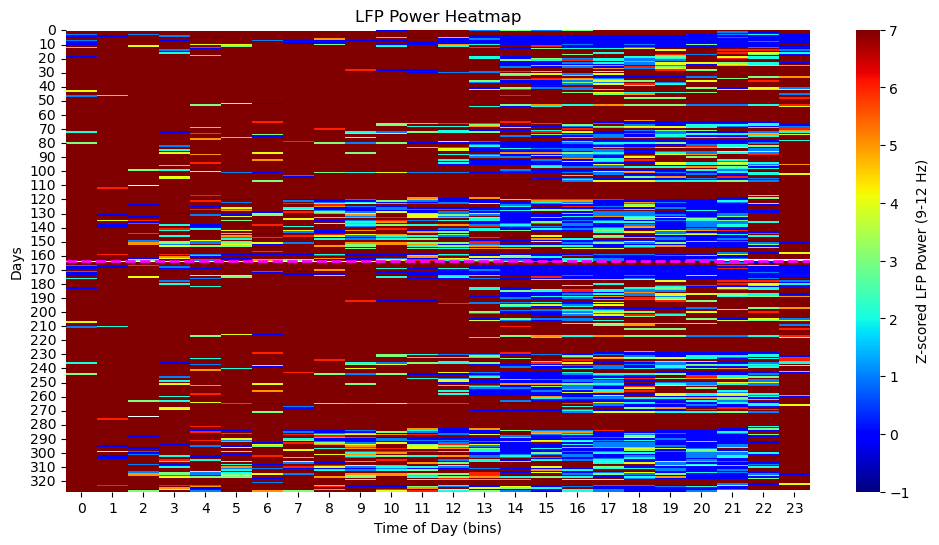

ValueError: Input contains NaN.

In [19]:
pre_matrix, post_matrix, combined_matrix, stimulus_day = load_and_process_lfp_data(
    'data/RNS_G_Pre_output.csv',
    'data/RNS_G_M1_output.csv')
pre_results = run_daily_cosinor_analysis(pre_matrix)
post_results = run_daily_cosinor_analysis(post_matrix)
print('Pre-stimulus daily cosinor results:', pre_results)
print('Post-stimulus daily cosinor results:', post_results)